**Context**

In this notebook, we will build an image classifier that can distinguish Pituitary Tumor from "No Tumor" MRI Scan images.

The dataset used in this notebook is available for download from Kaggle.

In [1]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
main_dir = '/content/drive/MyDrive/brain_tumor'

train_dir = os.path.join(main_dir, 'Training')
testing_dir = os.path.join(main_dir, 'Testing')

train_pituitary_dir = os.path.join(train_dir, 'pituitary_tumor')
train_no_dir = os.path.join(train_dir, 'no_tumor')

testing_pituitary_dir = os.path.join(testing_dir, 'pituitary_tumor')
testing_no_dir = os.path.join(testing_dir, 'no_tumor')

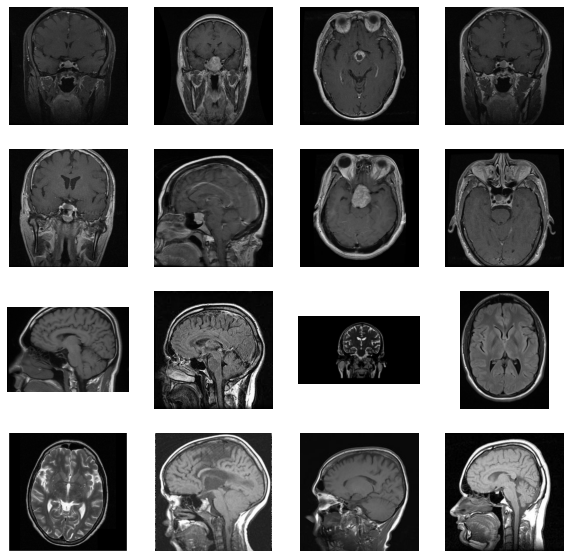

In [4]:
train_pituitary_file_names = os.listdir(train_pituitary_dir)
train_no_file_names = os.listdir(train_no_dir)

fig = plt.figure(figsize=(10, 5))
fig.set_size_inches(10, 10)

pituitary_img_paths = [os.path.join(train_pituitary_dir, file_name) for file_name in train_pituitary_file_names[:8]]
no_img_paths = [os.path.join(train_no_dir, file_name) for file_name in train_no_file_names[:8]]

for i, img_path in enumerate(pituitary_img_paths + no_img_paths):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

Data Augmentation

In [5]:
train_datagen = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=30, 
                              shear_range = 0.1,
                              zoom_range=0.1)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(224, 224))     

test_generator =  test_datagen.flow_from_directory(testing_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))

Found 830 images belonging to 2 classes.
Found 170 images belonging to 2 classes.


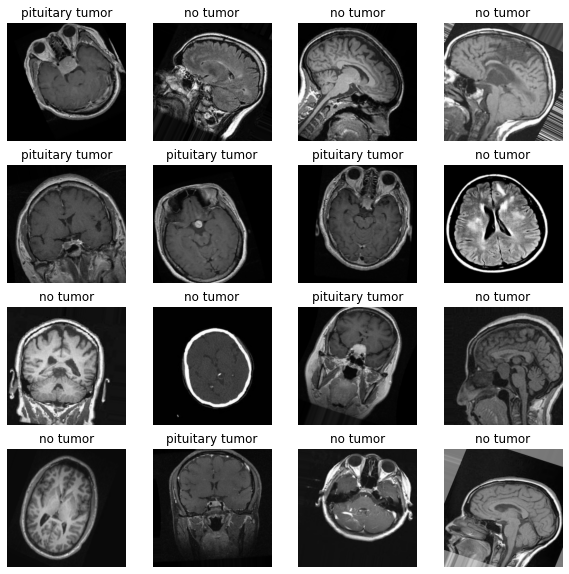

In [6]:
images, labels = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize = (10, 8))
fig.set_size_inches(10, 10)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label == 1: 
        ax.set_title('pituitary tumor')
    else:
        ax.set_title('no tumor')
    ax.axis('off')

CNN Model Building

In [7]:
from tensorflow.keras import backend
import tensorflow as tf
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [8]:
cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3), padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(16, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

In [9]:
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                        

In [10]:
model_history = cnn_model.fit(train_generator,
                              epochs=10)

Epoch 1/10
42/42 [==============================] - 126s 3s/step - loss: 0.9588 - accuracy: 0.7301
Epoch 2/10
42/42 [==============================] - 122s 3s/step - loss: 1.0463 - accuracy: 0.7627
Epoch 3/10
42/42 [==============================] - 123s 3s/step - loss: 0.8549 - accuracy: 0.7735
Epoch 4/10
42/42 [==============================] - 123s 3s/step - loss: 0.4793 - accuracy: 0.7976
Epoch 5/10
42/42 [==============================] - 127s 3s/step - loss: 0.3919 - accuracy: 0.8301
Epoch 6/10
42/42 [==============================] - 120s 3s/step - loss: 0.4200 - accuracy: 0.8566
Epoch 7/10
42/42 [==============================] - 120s 3s/step - loss: 0.3686 - accuracy: 0.8446
Epoch 8/10
42/42 [==============================] - 122s 3s/step - loss: 0.3088 - accuracy: 0.8783
Epoch 9/10
42/42 [==============================] - 122s 3s/step - loss: 0.2827 - accuracy: 0.8807
Epoch 10/10
42/42 [==============================] - 124s 3s/step - loss: 0.2969 - accuracy: 0.9096


In [11]:
cnn_model.evaluate(test_generator)

9/9 [==============================] - 6s 627ms/step - loss: 1.2636 - accuracy: 0.5647


[1.26358163356781, 0.5647059082984924]

Observation: The model is overfitting; training set accuracy is 0.90, but testing accuracy is 0.56. Let's build a model using a transfer learning (VGG 16)

Model Building using VGG 16

Take only convolutional and pooling layers from VGG16

In [12]:
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [13]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (224,224,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
for layer in vgg_model.layers:
    layer.trainable = False

In [15]:
model2= Sequential()
model2.add(vgg_model)
model2.add(Flatten())
model2.add(Dense(32, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(16, activation="relu"))
model2.add(Dense(1, activation="sigmoid"))

In [16]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model2_history = model2.fit(train_generator,
                                  epochs=10)

Epoch 1/10
42/42 [==============================] - 394s 9s/step - loss: 0.7312 - accuracy: 0.5542
Epoch 2/10
42/42 [==============================] - 391s 9s/step - loss: 0.5167 - accuracy: 0.7795
Epoch 3/10
42/42 [==============================] - 392s 9s/step - loss: 0.4237 - accuracy: 0.8867
Epoch 4/10
42/42 [==============================] - 392s 9s/step - loss: 0.3834 - accuracy: 0.9096
Epoch 5/10
42/42 [==============================] - 394s 9s/step - loss: 0.3452 - accuracy: 0.9313
Epoch 6/10
42/42 [==============================] - 394s 9s/step - loss: 0.3207 - accuracy: 0.9301
Epoch 7/10
42/42 [==============================] - 393s 9s/step - loss: 0.2936 - accuracy: 0.9506
Epoch 8/10
42/42 [==============================] - 392s 9s/step - loss: 0.2674 - accuracy: 0.9386
Epoch 9/10
42/42 [==============================] - 390s 9s/step - loss: 0.2245 - accuracy: 0.9687
Epoch 10/10
42/42 [==============================] - 392s 9s/step - loss: 0.1935 - accuracy: 0.9723


In [18]:
model2.evaluate(test_generator)

9/9 [==============================] - 78s 9s/step - loss: 0.3265 - accuracy: 0.9118


[0.3264748156070709, 0.9117646813392639]

The model2 is the final model. Training accuracy is 0.97, and the testing accuracy is 0.91.
